In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel , StepModel#Modelli vari, l'ultimo è Fermi (o Bose)

Welcome to JupyROOT 6.30/04


In [2]:
channel= 1

In [16]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [18]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_4_4_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_4_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [19]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT)

100000 100000


In [20]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 1 = 88869
#Noise ripulita su ch 1 = 77250


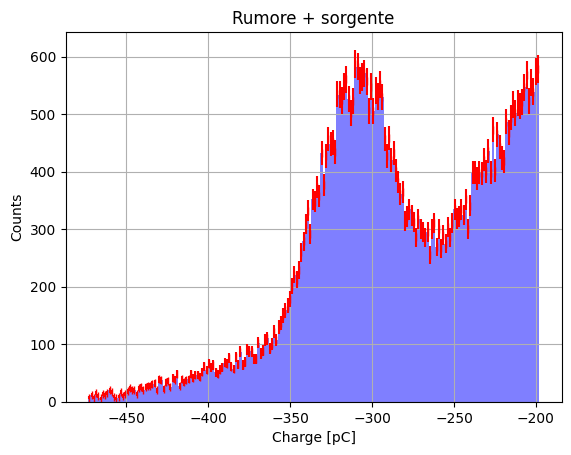

In [27]:
Nbin = 200
bin_lims = [int(Nbin *47 / 100), int(Nbin * 80/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


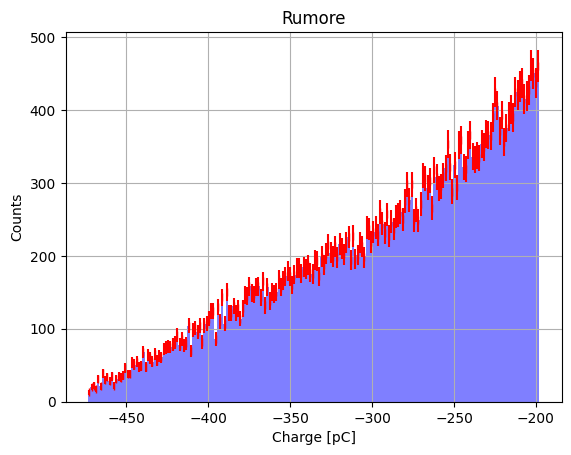

39876.0

In [28]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

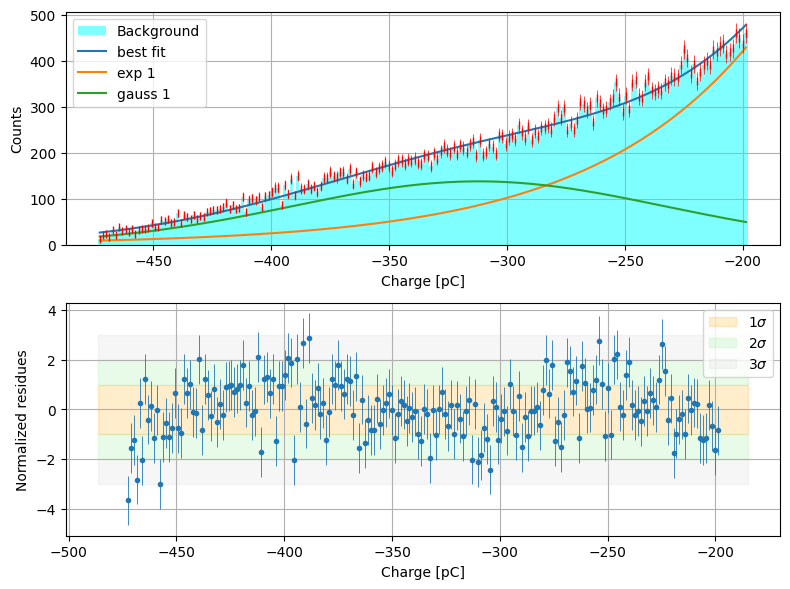

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 200
    # variables        = 5
    chi-square         = 258.977971
    reduced chi-square = 1.32809216
    Akaike info crit   = 61.6851275
    Bayesian info crit = 78.1767143
    R-squared          = 0.99990808
[[Variables]]
    e1_amplitude:  7229.09726 +/- 6039.77058 (83.55%) (init = 3701.977)
    e1_decay:     -70.3613702 +/- 23.7951221 (33.82%) (init = -105.9937)
    g1_amplitude:  27253.5691 +/- 16646.5269 (61.08%) (init = 70298.13)
    g1_center:    -312.127473 +/- 20.9989631 (6.73%) (init = -246.6227)
    g1_sigma:      79.0002216 +/- 15.2384455 (19.29%) (init = 52.30516)
    g1_fwhm:       186.031299 +/- 35.8837962 (19.29%) == '2.3548200*g1_sigma'
    g1_height:     137.627483 +/- 57.6917808 (41.92%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_ampli

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,7229.09726,6039.77058,(83.55%),3701.9771651437145,0.00000000,inf,True,
e1_decay,-70.3613702,23.7951221,(33.82%),-105.99369655731745,-inf,inf,True,
g1_amplitude,27253.5691,16646.5269,(61.08%),70298.13061523438,0.00000000,inf,True,
g1_center,-312.127473,20.9989631,(6.73%),-246.62267837524413,-inf,inf,True,
g1_sigma,79.0002216,15.2384455,(19.29%),52.30515670776367,0.00000000,inf,True,
g1_fwhm,186.031299,35.8837962,(19.29%),123.16922911857606,-inf,inf,False,2.3548200*g1_sigma
g1_height,137.627483,57.6917808,(41.92%),536.1784512,-inf,inf,False,"0.3989423*g1_amplitude/max(1e-15, g1_sigma)"
g2_amplitude,0.00000000,0.00000000,,0.0,-inf,inf,False,
g2_center,-320.000000,0.00000000,(0.00%),-320.0,-inf,inf,False,
g2_sigma,25.0000000,0.00000000,(0.00%),25.0,0.00000000,inf,False,


In [29]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)

 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt =-0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
#frac=1.5
#params["g1_amplitude"].expr=str(frac)+'*e1_amplitude'




model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
print(frac)
params.update(result.params)

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      7229        0      inf     6040     True     None     None
e1_decay        -70.36     -inf      inf     23.8    False     None     None
g1_amplitude  2.725e+04        0      inf 1.665e+04     True     None     None
g1_center       -312.1     -inf      inf       21    False     None     None
g1_fwhm            186     -inf      inf    35.88    False 2.3548200*g1_sigma     None
g1_height        137.6     -inf      inf    57.69    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            79        0      inf    15.24    False     None     None
g2_amplitude      1000        0      inf        0     True     None     None
g2_center         -350     -350     -250        0     True     None     None
g2_fwhm          2.355     -inf      inf        0    False 2.3548200*g2_sigma     None
g2_height        398.9     -inf      inf        0    False 0.3989423*g2_amplitude/max(1e-15, g

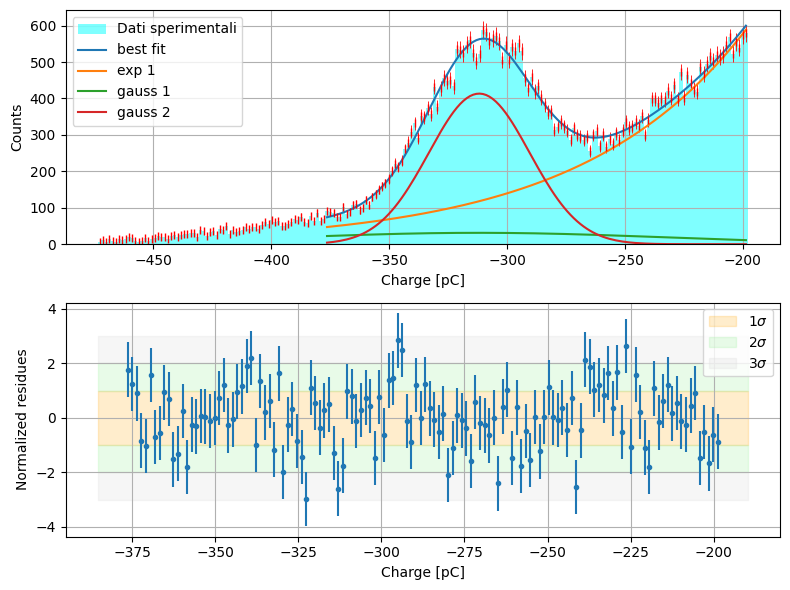

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 130
    # variables        = 5
    chi-square         = 174.528024
    reduced chi-square = 1.39622419
    Akaike info crit   = 48.2916136
    Bayesian info crit = 62.6292859
    R-squared          = 0.99993606
[[Variables]]
    e1_amplitude:  9920.96252 +/- 124.049098 (1.25%) (init = 7229.097)
    e1_decay:     -70.36137 (fixed)
    g1_amplitude:  6195.11283 +/- 1201.65027 (19.40%) (init = 27253.57)
    g1_center:    -312.1275 (fixed)
    g1_sigma:      79.00022 (fixed)
    g1_fwhm:       186.031302 +/- 0.00000000 (0.00%) == '2.3548200*g1_sigma'
    g1_height:     31.2846282 +/- 6.06819970 (19.40%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  22168.6264 +/- 617.084949 (2.78%) (init = 1000)
    g2_center:    -311.785913 +/- 0.32511078 (0.10%) (ini

In [30]:

params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False


params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True



params["g2_amplitude"].value = 1000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -350          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -250
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["g2_amplitude"].min=0
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
#params["e1_amplitude"].expr=str(frac)+'*g1_amplitude'


model = exp1 + gauss1 + gauss2 #+ fd1

#params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando
params.pretty_print()

start=int(Nbin *35 / 100)
stop=int(Nbin * 100/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['g1_'], label='gauss 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
#ax1.plot(centersCs[start:stop], comps['Fermi_Dirac'], label='fd1')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

channel =2

In [3]:
channel=2

In [4]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [17]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_27_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_BIS.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

noise_file2 = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024.root'  #File di rumore di riferimento per il canale
RunNoise2=uproot.open(noise_file2) 

In [20]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN_ = np.array(RunNoise['tree'].arrays()['charge'])
chargeN = np.append(chargeN_, np.array(RunNoise2['tree'].arrays()['charge']))
ampN_ = np.array(RunNoise2['tree'].arrays()['amp'])
ampN=np.append(ampN_, np.array(RunNoise['tree'].arrays()['amp']))

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT, len(chargeN), len(ampN))

1000000 100000 150000 150000


In [21]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 2 = 801505
#Noise ripulita su ch 2 = 100949


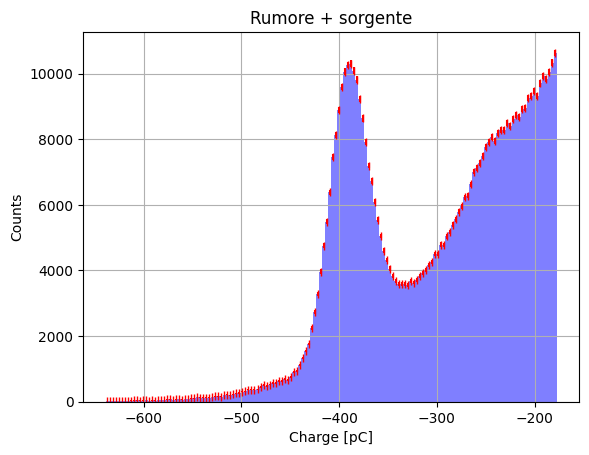

In [89]:
Nbin = 150
bin_lims = [int(Nbin *37 / 100), int(Nbin * 85/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()

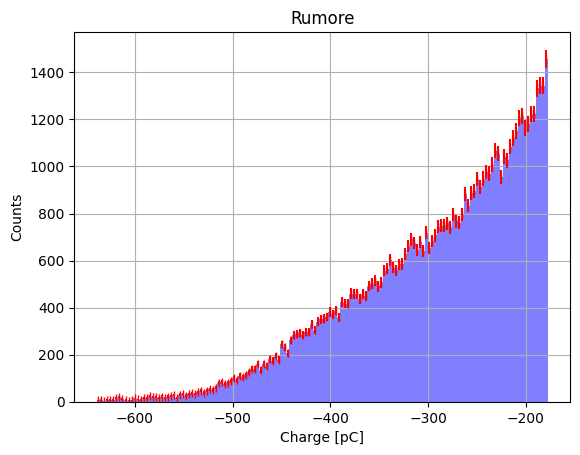

64969.0

In [90]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

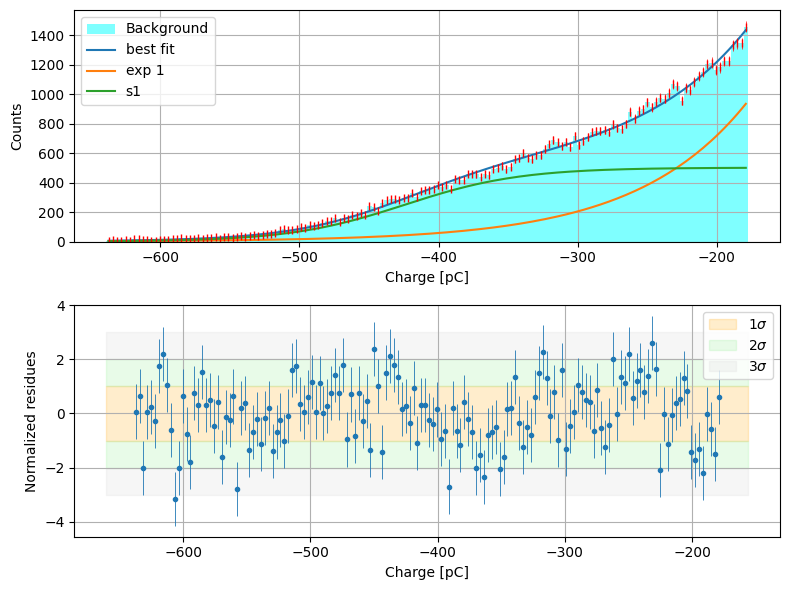

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 150
    # variables        = 5
    chi-square         = 206.210125
    reduced chi-square = 1.42213880
    Akaike info crit   = 57.7390572
    Bayesian info crit = 72.7922336
    R-squared          = 0.99999126
[[Variables]]
    e1_amplitude:  8844.94064 +/- 1282.12126 (14.50%) (init = 22474.3)
    e1_decay:     -79.6232150 +/- 6.25512566 (7.86%) (init = -85.51036)
    g2_amplitude:  3720692 (fixed)
    g2_center:    -284.017 (fixed)
    g2_sigma:      116.8926 (fixed)
    g2_fwhm:       275.261062 +/- 0.00000000 (0.00%) == '2.3548200*g2_sigma'
    g2_height:     12698.3334 +/- 0.00000000 (0.00%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_amplitude:  501.598738 +/- 42.0833810 (8.39%) (init = 380)
    s1_center:    -423.957743 +/- 4.10089537 (0.97%) (init = -334)
    s1_sigma:  

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,8844.94064,1282.12126,(14.50%),22474.299948586988,0.00000000,inf,True,
e1_decay,-79.6232150,6.25512566,(7.86%),-85.51035646987363,-inf,inf,True,
g2_amplitude,3720691.85,0.00000000,(0.00%),3720691.8545150757,-inf,inf,False,
g2_center,-284.017011,0.00000000,(0.00%),-284.01701081473874,-inf,inf,False,
g2_sigma,116.892612,0.00000000,(0.00%),116.89261245727539,0.00000000,inf,False,
g2_fwhm,275.261062,0.00000000,(0.00%),275.26106166664124,-inf,inf,False,2.3548200*g2_sigma
g2_height,12698.3334,0.00000000,(0.00%),12698.333409,-inf,inf,False,"0.3989423*g2_amplitude/max(1e-15, g2_sigma)"
s1_amplitude,501.598738,42.0833810,(8.39%),380.0,-inf,inf,True,
s1_center,-423.957743,4.10089537,(0.97%),-334.0,-inf,inf,True,
s1_sigma,41.3536117,2.51201219,(6.07%),50.0,-inf,inf,True,


In [91]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
#gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
#params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 1000, center = -370, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(gauss2.guess(binCs, x=centersCs))
params.update(s1.make_params(amplitude = 380, center = -334, sigma = 50))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params.update(gauss1.guess(binN, x=centersN)) 
params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

params["s2_amplitude"].vary= False
params["s2_center"].vary=False
params["s2_sigma"].vary=False

params["e1_amplitude"].min=0
#params["s1_center"].set(value=-330, min=-380)

model = exp1 + s1 

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

#frac=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
#print(frac)
params.update(result.params)

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      8845        0      inf     1282     True     None     None
e1_decay        -79.62     -inf      inf    6.255     True     None     None
g1_amplitude  2.417e+05     -inf      inf        0    False     None     None
g1_center       -234.3     -inf      inf        0    False     None     None
g1_fwhm          130.4     -inf      inf        0    False 2.3548200*g1_sigma     None
g1_height         1741     -inf      inf        0    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma         55.37        0      inf        0    False     None     None
g2_amplitude  3.721e+06     -inf      inf        0     True     None     None
g2_center         -388     -inf      inf        0     True     None     None
g2_fwhm          44.74     -inf      inf        0    False 2.3548200*g2_sigma     None
g2_height     7.812e+04     -inf      inf        0    False 0.3989423*g2_amplitude/max(1e-15, 

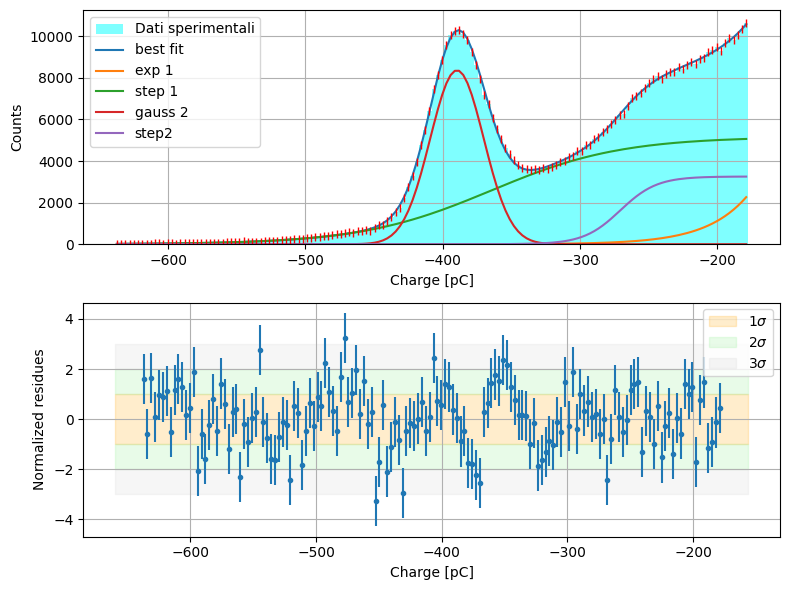

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 834
    # data points      = 150
    # variables        = 11
    chi-square         = 223.220285
    reduced chi-square = 1.60590133
    Akaike info crit   = 81.6285719
    Bayesian info crit = 114.745560
    R-squared          = 0.99999989
[[Variables]]
    e1_amplitude:  891164.790 +/- 1295505.93 (145.37%) (init = 8844.941)
    e1_decay:     -29.9517569 +/- 7.79350267 (26.02%) (init = -79.62322)
    g2_amplitude:  409290.085 +/- 3106.58882 (0.76%) (init = 3720692)
    g2_center:    -389.635928 +/- 0.10396013 (0.03%) (init = -388)
    g2_sigma:      19.5158549 +/- 0.11397348 (0.58%) (init = 19)
    g2_fwhm:       45.9563254 +/- 0.26838702 (0.58%) == '2.3548200*g2_sigma'
    g2_height:     8366.69101 +/- 47.1455776 (0.56%) == '0.3989423*g

In [92]:

#params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
#params["g1_center"].vary = False  #lasciando libere le ampiezze

params["e1_decay"].vary = True

params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -388, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params["s2_amplitude"].set(value=921, min=100, vary= True)
params["s2_center"].set(value=-272, min=-280, vary=True)
params["s2_sigma"].set(value=5, vary=True)

params["s1_amplitude"].set(vary = True, min=0)
params["s1_center"].set(vary = True)
params["s1_sigma"].vary = True



model = exp1 + s1 + gauss2 +s2

params.pretty_print()

start=int(Nbin *0/ 100)
stop=int(Nbin * 100/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['s1_'], label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [ ]:
params["g2_amplitude"].value = 220354.754     #Parametri da aggiustare to make the magic happen
params["g2_amplitude"].min=10000
params["g2_sigma"].value=25.0304199
params["g2_sigma"].min=10
params["g2_sigma"].max=100
params["g2_center"].min = -440          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -350
params["g2_center"].set(value = -390)
params["g2_sigma"].set(value = 30)
params["g1_amplitude"].min=10000
params["e1_amplitude"].min=10000

params["s1_amplitude"].set(value = 1000)
params["s1_center"].set(value = -250)
params["s1_sigma"].set(value = 1)
params["s1_center"].min = -300
params["s1_center"].max = -100

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)